In [2]:
from spot import *

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import os, torch
import numpy as np
import pandas as pd
import scienceplots
import h5py
from tqdm.notebook import tqdm 

plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
import math

lr = 0.0001
dims = 4

class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, max_len=5000):
            super(PositionalEncoding, self).__init__()
            self.dropout = nn.Dropout(p=dropout)

            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
            pe += torch.sin(position * div_term)
            pe += torch.cos(position * div_term)
            pe = pe.unsqueeze(0).transpose(0, 1)
            self.register_buffer('pe', pe)

        def forward(self, x, pos=0):
            x = x + self.pe[pos:pos+x.size(0), :]
            return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None, is_causal=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt


# Proposed Model + Self Conditioning + Adversarial + MAML (VLDB 22)
class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = lr
        self.batch = 2048
        self.n_feats = feats
        self.n_window = 10
        self.n_window_start = self.n_window
        self.n_window_slide = 1

        self.pos_encoder = PositionalEncoding(2 * feats, 0, self.n_window)
        encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=512)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 2)
        decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=256)
        self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
        decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=256)
        self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
        self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

    def encode(self, src, c, tgt):
        src = torch.cat((src, c), dim=2)
        src = src * math.sqrt(self.n_feats)
        src = self.pos_encoder(src)
        #mask = torch.triu(torch.ones((10, 10), device=src.device, dtype=torch.bool), diagonal=1) == 1
        memory = self.transformer_encoder(src)#, mask=mask)
        tgt = tgt.repeat(1, 1, 2)
        return tgt, memory

    def forward(self, src, tgt):
        # Phase 1 - Without anomaly scores
        c = torch.zeros_like(src)
        x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))

        # Phase 2 - With anomaly scores
        c = (x1 - src) ** 2
        x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))

        return x1, x2


class AlladiCNNLSTM(nn.Module):
    def __init__(self, feats):
        super(AlladiCNNLSTM, self).__init__()
        self.name = 'AlladiCNNLSTM'
        self.batch = 2048
        self.lr = lr
        self.n_feats = feats
        self.n_window = 10
        self.n_window_slide = 1
        self.n_window_start = self.n_window
        self.n_hidden = 256
        self.n_layers = 4

        # Define the CNN layers
        self.cnn = nn.Conv1d(feats, 20, kernel_size=3)

        # Define the LSTM layers
        self.lstm = nn.LSTM(20, self.n_hidden, self.n_layers, batch_first=True)

        # Fully connected layer
        # self.fc = nn.Sequential(nn.Linear(20 * self.n_hidden, self.n_feats), nn.Sigmoid())
        self.fc = nn.Sequential(nn.Linear(self.n_hidden, self.n_feats), nn.Sigmoid())

    def forward(self, src):
        # Forward pass through CNN
        src = src.permute(1, 2, 0)
        src = self.cnn(src)
        src = src.permute(0, 2, 1)

        # Forward pass through LSTM
        out, _ = self.lstm(src)

        # out = out.reshape(-1, out.shape[1] * out.shape[2])
        out = out[:, -1]
        # Decode the hidden state of the last time step
        out = self.fc(out)

        return out.unsqueeze(0)

    
def load_model(model_class, checkpoint):
    model = model_class(dims)
    model.to(device)
    if os.path.exists(checkpoint):
        print(f"Loading pre-trained model: {model.name}")
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        accuracy_list = checkpoint['accuracy_list']

    return model, accuracy_list

In [4]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class HDF5Dataset(Dataset):
    def __init__(self, h5_data, chunk_size=1000, device='cpu', less=False):
        self.h5_data = h5_data
        if less:
            self.h5_data = cut_array_window_first(0.2, self.h5_data)
        self.device = device
        self.chunk_size = chunk_size
        self.chunk_start = -1
        self.chunk_end = 0
        self.chunk(0)
        
    def chunk(self, idx):
        if  idx < self.chunk_start or idx >= self.chunk_end:
            self.chunk_start = (idx // self.chunk_size) * self.chunk_size
            self.chunk_end = self.chunk_start + self.chunk_size
            chunk = self.h5_data[:, self.chunk_start:self.chunk_end]
            if hasattr(self, '_chunk'):
                del self._chunk
            self._chunk = torch.from_numpy(chunk).float().to(self.device)
        bounded_idx = idx - self.chunk_start
        return self._chunk, bounded_idx

    def __len__(self):
        return self.h5_data.shape[1]

    def __getitem__(self, idx):
        chunk, bounded_idx = self.chunk(idx)
        data = chunk[:, bounded_idx]
        return data, data

In [5]:
# pot
from sklearn.metrics import roc_auc_score

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)

    acc = (TP + TN) / (TP + FP + TN + FN)  # + 0.00001)
    precision = TP / (TP + FP)  # + 0.00001)
    recall = TP / (TP + FN)  # + 0.00001)
    f1 = 2 * precision * recall / (precision + recall)  # + 0.00001)
    try:
        roc_auc = roc_auc_score(actual, predict)
    except Exception:
        roc_auc = 0
    p_t = f1, precision, recall, TP, TN, FP, FN, roc_auc, acc
    return p_t
    # metrics = {
    #     'f1': p_t[0],
    #     'precision': p_t[1],
    #     'recall': p_t[2],
    #     'TP': p_t[3],
    #     'TN': p_t[4],
    #     'FP': p_t[5],
    #     'FN': p_t[6],
    #     'ROC/AUC': p_t[7],
    #     'accuracy': p_t[8],
    #     # 'pot-latency': p_latency
    # }
    # return metrics

def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False,
                    label_seq=None):
    if len(score) != len(label):
        raise ValueError(f"score ({len(score)}) and label ({len(label)}) must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

def pot_eval(init_score, score, label, q=1e-5, level=0.02, multi=False):
    label_seq = None
    if multi:
        label_main_attack = label[:, 1]
        label_seq = label[:, 2]
        label = label[:, 0]

    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(init_score, score)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])
    pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True, label_seq=label_seq)
    # DEBUG - np.save(f'{debug}.npy', np.array(pred))
    # DEBUG - print(np.argwhere(np.array(pred)))
    p_t = calc_point2point(pred, np.where(label > 0, 1, 0))

    metrics = {
        'f1': p_t[0],
        'precision': p_t[1],
        'recall': p_t[2],
        'TP': p_t[3],
        'TN': p_t[4],
        'FP': p_t[5],
        'FN': p_t[6],
        'ROC/AUC': p_t[7],
        'accuracy': p_t[8],
        'threshold': pot_th,
        # 'pot-latency': p_latency
    }

    if multi:
        label_types = np.unique(label_main_attack)
        for lb in label_types:
            if lb == 0:
                mask = np.ones_like(label, dtype=bool)
            else:
                mask = label_main_attack == lb
            pred_only_curr_lb = pred[mask]
            if lb == 0:
                cond = label[mask] == 0
                pred_only_curr_lb = 1 - pred_only_curr_lb
            else:
                cond = label[mask] > 0

            actual = np.where(cond, 1, 0)
            p_t = calc_point2point(pred_only_curr_lb, actual)
            metrics[int(lb)] = {
                'f1': p_t[0],
                'precision': p_t[1],
                'recall': p_t[2],
                'TP': p_t[3],
                'TN': p_t[4],
                'FP': p_t[5],
                'FN': p_t[6],
                'ROC/AUC': p_t[7],
                'accuracy': p_t[8],
                'threshold': pot_th,
            }

    # print('POT result: ', p_t, pot_th, p_latency)
    return metrics, np.array(pred)


In [124]:
# model, acc_list = load_model(AlladiCNNLSTM, 'checks/AlladiCNNLSTM_VeReMiH510/model-e149.ckpt')
# model95, acc_list95 = load_model(AlladiCNNLSTM, 'checks/AlladiCNNLSTM_VeReMiH51095/model-e149.ckpt')
# model90, acc_list90 = load_model(AlladiCNNLSTM, 'checks/AlladiCNNLSTM_VeReMiH51090/model-e134.ckpt')
model, acc_list = load_model(TranAD, 'checks/TranAD_VeReMiH510_final/model-e149.ckpt')
model95, acc_list95 = load_model(TranAD, 'checks/TranAD_VeReMiH51095_final/model-e139.ckpt')
model90, acc_list90 = load_model(TranAD, 'checks/TranAD_VeReMiH51090_final/model-e134.ckpt')
loss = nn.MSELoss(reduction = 'none')
pctg = 'full'
lm = (0.99, 1)

Loading pre-trained model: TranAD
Loading pre-trained model: TranAD
Loading pre-trained model: TranAD


In [7]:
f = h5py.File('out_veremi/veremi-atk-10.h5')
bs = 5000
dataset = HDF5Dataset(f['test'], chunk_size=bs * 100, device=device)
dataloader = DataLoader(dataset, batch_size=bs)

In [8]:
def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_curve(y_t, y_p, l, a_s, p, title, final=False, first=False, thresh=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_ylabel('Value')
    ax1.set_title(title)
    if not final:
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
    ax3 = ax1.twinx()
    # ax3.plot(l, '--', linewidth=0.1, alpha=0.5)
    # ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
    # ax4 = ax1.twinx()
    # ax4.plot(p, '--', linewidth=0.1, alpha=0.5)
    # ax4.fill_between(np.arange(p.shape[0]), p, color='red', alpha=0.3)
    if first: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
    ax2.plot(smooth(a_s), linewidth=0.2, color='g')
    ax2.axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Anomaly Score')


In [9]:
def test_all(datal, model):
    losses = []
    zs = []
    for d, _ in tqdm(datal):
        d = d.to(device)
        local_bs = d.shape[0]
        window = d.permute(1, 0, 2)
        elem = window[-1, :, :].view(1, local_bs, dims)
        if model.name == 'TranAD':
            params = (window, elem)
        else:
            params = (window,)
        z = model(*params)
        if isinstance(z, tuple): z = z[1]
        l = loss(z, elem)[0]
        zs.append(z.cpu().detach())
        losses.append(l.cpu().detach())
        
    l = torch.cat(losses, 0)
    z = torch.cat(zs, 1)
    return l.detach().cpu().numpy(), z.detach().cpu().numpy()[0]

In [125]:
all_loss, all_z = test_all(dataloader, model)
all_loss95, all_z95 = test_all(dataloader, model95)
all_loss90, all_z90 = test_all(dataloader, model90)

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(precision, recall):
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def find_optimal_threshold(mean_score, labels, plot=True):
    precision, recall, thresholds = precision_recall_curve(
        labels > 0, mean_score)
    f1_scores = 2*recall*precision/(recall+precision)

    if plot:
        plot_pr_curve(precision, recall)

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)

    return best_threshold, best_f1

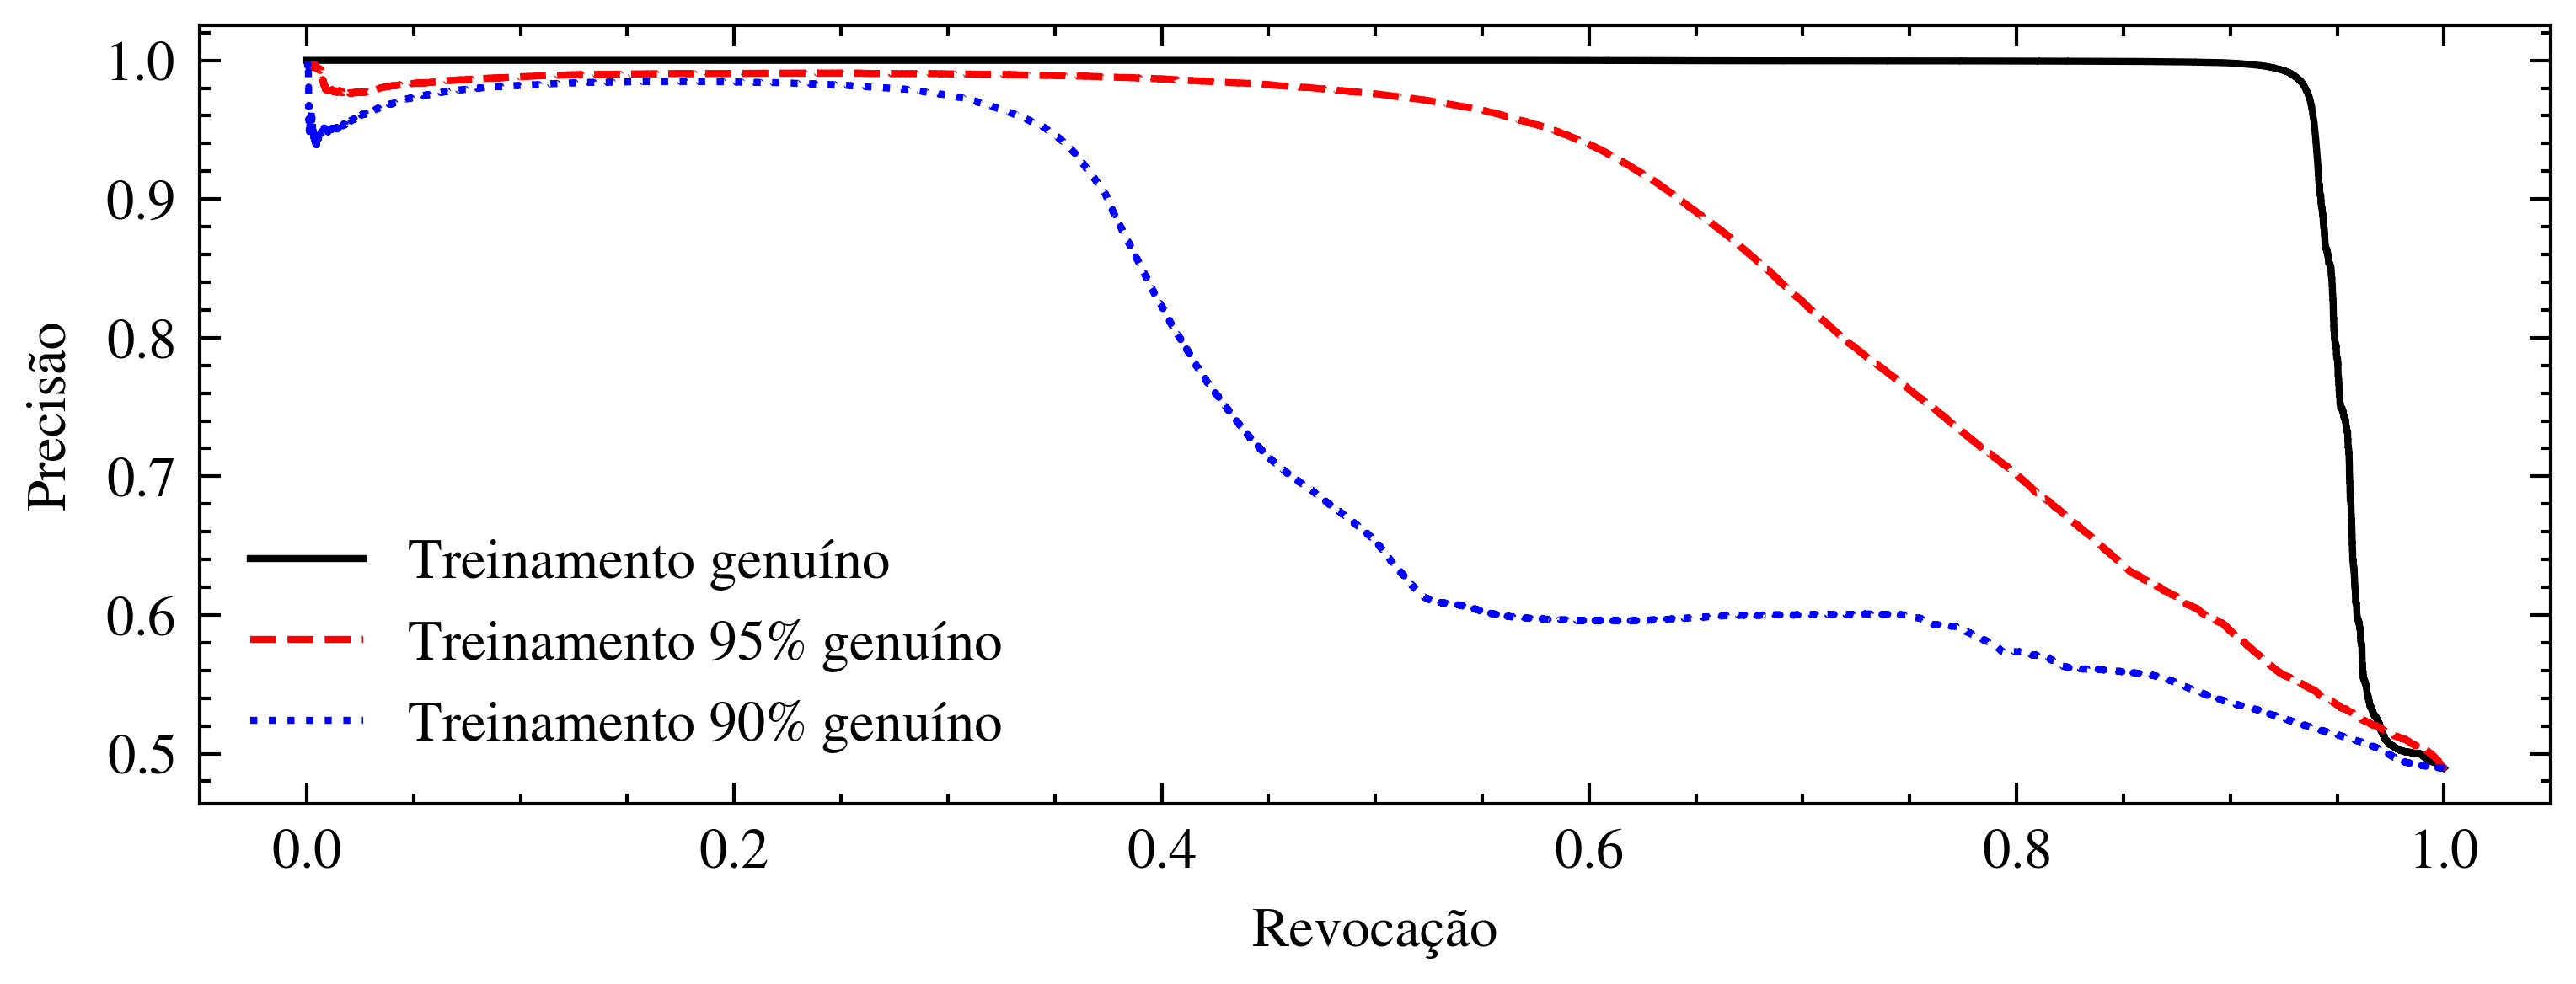

In [12]:
#matplotlib.rcParams.update({'font.size': 12})

ps, rs = [], []
def pr(loss):
    mean_score = np.mean(loss, axis=1)
    label = f['test_labels'][:, 0]
    precision, recall, thresholds = precision_recall_curve(label > 0, mean_score)
    return recall, precision


r1, p1 = pr(all_loss)
r2, p2 = pr(all_loss95)
r3, p3 = pr(all_loss90)
plt.plot(r1, p1, label='Treinamento genuíno')
plt.plot(r2, p2, label='Treinamento 95% genuíno')
plt.plot(r3, p3, label='Treinamento 90% genuíno')

plt.xlabel('Revocação')
plt.ylabel('Precisão')

plt.legend()


plt.savefig('pr-curve.png', bbox_inches='tight')
plt.show()

In [126]:
T, f1 = find_optimal_threshold(mean_score=np.mean(all_loss, axis=1), labels=f['test_labels'][:, 0] > 0, plot=False)
T, f1

(1.8771739e-06, 0.8841230804330832)

In [139]:
dataset_train = HDF5Dataset(f[f'train_90_genuine'], chunk_size=bs * 100, device=device)
dataloader_train = DataLoader(dataset_train, batch_size=bs)

all_loss_train, _ = test_all(dataloader_train, model90)
all_loss_train_mean = np.mean(all_loss_train, axis=1)

  0%|          | 0/669 [00:00<?, ?it/s]

In [140]:
#lm = (0.3, 1) # (0.3, 1) (0.75, 1) (0.99, 1) alladi
lm = (0.25, 1) # (0.25, 1) (0.64, 1) (0.95, 1) tranad

metrics, _ = pot_eval(all_loss_train_mean, np.mean(all_loss90, axis=1), f['test_labels'], multi=True)
T = metrics['threshold']

In [141]:
metrics2 = metrics.copy() 
code_to_label = {
    10: "Disruptivo",
    11: "Repetição de dados",
    9: "Parada eventual",
    13: "Negação de serviço",
    14: "Negação de serviço aleatória",
    15: "Negação de serviço disruptiva",
    16: "Repetição de dados sybil",
    17: "Congestionamento sybil",
    18: "Negação de serviço aleatória sybil",
    19: "Negação de serviço disruptiva sybil",
}

code_to_code = {
    #0: "Genuíno",
    10: 10,
    11: 11,
    9: 12,
    13: 13,
    14: 14,
    15: 15,
    16: 16,
    17: 17,
    18: 18,
    19: 19,
}

separated = []

for attack in code_to_label.keys():
    metrics2[attack]['key'] = code_to_label[attack]
    metrics2[attack]['code'] = code_to_code[attack]
    separated.append(metrics2[attack])
    del metrics2[attack]

metrics2['key'] = 'Total'
metrics2['code'] = 20
separated.append(metrics2)

separated = pd.DataFrame(separated).sort_values('code')
separated = separated[['key', 'accuracy', 'precision', 'recall', 'f1', 'ROC/AUC']].set_index('key', drop=True)
separated.to_csv('tranad_90.csv')
separated

,accuracy,precision,recall,f1,ROC/AUC
key,,,,,
Disruptivo,0.484321,0.359736,0.964484,0.524021,0.624272
Repetição de dados,0.457938,0.347197,0.891669,0.499787,0.580215
Parada eventual,0.408884,0.262305,0.776808,0.392182,0.532990
Negação de serviço,0.547484,0.600507,0.727233,0.657822,0.503599
Negação de serviço aleatória,0.691247,0.645839,0.999125,0.784545,0.647160
Negação de serviço disruptiva,0.665420,0.634432,0.961663,0.764503,0.621364
Repetição de dados sybil,0.574863,0.679696,0.715147,0.696971,0.493425
Congestionamento sybil,0.484608,0.367943,0.908529,0.523767,0.600468
Negação de serviço aleatória sybil,0.613789,0.548465,0.999283,0.708219,0.636263


In [113]:
attack_to_group = {}
attack_types = np.unique(f['test_labels'][:, 0])
mid = f['test_labels'].shape[0] // 2
for attack_type in tqdm(attack_types):
    idxs = f['test_labels'][:, 0] == attack_type
    attack_to_group[attack_type] = np.unique(f['test_labels'][:, 2][idxs])

  0%|          | 0/11 [00:00<?, ?it/s]

In [90]:
attack_to_group[0][100]

1147

In [91]:
attack_to_group[17][100]

4112

In [92]:
fps = []
sizes = []
pctgs = []

group_idx = np.isin(f['test_labels'][:, 2], attack_to_group[0])
print('a')
#preds, l = eval_group(f, group_idx)
print('b')
# for i in (pbar := tqdm()): #[-4000:-3500]):
#     l = l.mean(axis=1)
#     s = np.sum(l > 0.0005618696491893652)
#     size = np.sum(group_idx)
#     pctg = 100 * s / size
#     fps.append(s)
#     sizes.append(size)ROC/AUC 	ROC/AUC 	
#     pctgs.append(pctg)
#     pbar.set_description(f"Last FP {s}, Last Size {size}: {pctg:.4}")

a
b


In [142]:
id_to_feat = ['Posição X', 'Posição Y', 'Velocidade X', 'Velocidade Y']

def eval_group(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    tgt = test[-1].unsqueeze(0)
    if model.name == 'TranAD':
        params = (test, tgt)
    else:
        params = (test,)
    out = model90(*params)
    if isinstance(out, tuple): out = out[1]
    l = loss(out, tgt).detach().cpu().numpy()[0]    
    return out.detach().cpu().numpy(), l


# def plot_group(h5file, group, thresh):
#     group_idx = h5file['test_labels'][:, 2] == group
#     values = h5file['test'][-1, group_idx]
#     labels = h5file['test_labels'][group_idx, 0]
#     preds, l = eval_group(h5file, group_idx)
#     fig, axes = plt.subplots(nrows=2 * (values.shape[1]) + 1,
#                              ncols=1,
#                              sharex=True,
#                              figsize=(5, 5))    
#     for i in range(0, values.shape[1] * 2, 2):
#         feat = i // 2
#         axes[i].title.set_text(id_to_feat[feat])
#         axes[i].title.set_fontsize(6)
#         axes[i].plot(values[:, feat], linewidth=0.2, color='b')
#         axes[i].plot(preds[0, :, feat], '-', alpha=0.6, linewidth=0.3, color='r')
#         axes[i].grid()
        
#         axes[i + 1].plot(l[:, feat], '-', alpha=0.6, linewidth=0.3, color='g')
#         axes[i + 1].grid()

#     axes[-1].title.set_text('Score de todas as dimensões')
#     axes[-1].title.set_fontsize(6)
#     axes[-1].plot(l.mean(axis=1), '-', alpha=0.6, linewidth=0.3, color='g')
#     axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
#     axes[-1].grid()

In [22]:
V = pd.read_feather('out_veremi/veremi-atk.feather')

vals = V[['snd_pos_x', 'snd_pos_y']]
min_a = vals.min(axis=0)
max_a = vals.max(axis=0)

map_data = V[V.attack_type == 0].sample(frac=0.8)[['snd_pos_x', 'snd_pos_y']]
norm_map_data = (map_data - min_a) / (max_a - min_a + 0.0001)
norm_map_data.describe()

,snd_pos_x,snd_pos_y
count,3.139434e+06,3.139434e+06
mean,5.008275e-01,5.224804e-01
std,5.066019e-02,4.573876e-02
min,4.289423e-01,4.206092e-01
25%,4.541447e-01,4.827423e-01
50%,4.891843e-01,5.313200e-01
75%,5.434075e-01,5.595252e-01
max,6.058043e-01,6.334053e-01


In [115]:
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, fontsize=4)

id_to_feat = ['Posição X', 'Posição Y', 'Velocidade X', 'Velocidade Y']

def plot_group(h5file, group, thresh):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][-1, group_idx]
    labels = h5file['test_labels'][group_idx, 0]
    preds, l = eval_group(h5file, group_idx)
    fig = plt.figure(figsize=(5, 5))
    
    gs0 = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0)
    
    gs00 = gs0[0].subgridspec(nrows=5, ncols=1, hspace=0.4)
    gs01 = gs0[1].subgridspec(nrows=2, ncols=1)

    for i in range(values.shape[1]):
        gs00i = gs00[i].subgridspec(nrows=2, ncols=1)
        ax00i0 = fig.add_subplot(gs00i[0])
        ax00i0.set_title(id_to_feat[i], fontsize=6)
        ax00i1 = fig.add_subplot(gs00i[1])

        lval, = ax00i0.plot(values[:, i], linewidth=0.2, color='b', label='Original')
        lpred, = ax00i0.plot(preds[0, :, i], '--', alpha=0.6, linewidth=0.3, color='r', label='Reconstruída')
        ax00i0.set_ylabel("Valor", labelpad=-2, fontsize=3.5)
        ax00i0.tick_params(labelbottom=False, labelleft=False)
        
        lloss, = ax00i1.plot(l[:, i], '-', alpha=0.6, linewidth=0.3, color='g', label='Perda')
        ax00i1.set_ylim(l[:, i].min() - l[:, i].min() * 0.8, l[:, i].max() + l[:, i].max() * 0.1)
        ax00i1.set_xlabel("Tempo", labelpad=-2, fontsize=3.5)
        ax00i1.set_ylabel("Perda", labelpad=-2, fontsize=3.5)
        ax00i1.tick_params(labelbottom=False, labelleft=False)
        
        if i == 0:
            ax00i0.legend([lval, lpred, lloss],
                          ['Original', 'Reconstruída', 'Perda'],
                          fontsize=4,
                          loc='upper left',
                          bbox_to_anchor=(0, 2.1))
        
    ax00n = fig.add_subplot(gs00[values.shape[1]])
    ax00n.set_title('Média das perdas', fontsize=6)

    ax00n.plot(l.mean(axis=1), '-', alpha=0.6, linewidth=0.3, color='y',  label='Escore')

    ax00n.axhline(y=thresh, color='orange', linestyle='--', linewidth=0.2, label='Limiar')
    ax00n.legend(fontsize=4,
                 loc='upper left',
                 bbox_to_anchor=(0, 1.35))
    
    ax00n.set_xlabel("Tempo", labelpad=-2, fontsize=3.5)
    ax00n.set_ylabel("Perda", labelpad=-2, fontsize=3.5)
    ax00n.tick_params(labelbottom=False, labelleft=False)
    
    min_x, max_x = norm_map_data['snd_pos_x'].min() - 0.01, norm_map_data['snd_pos_x'].max() + 0.01
    min_y, max_y = norm_map_data['snd_pos_y'].min() - 0.01, norm_map_data['snd_pos_y'].max() + 0.01

    ax010 = fig.add_subplot(gs01[0])
    ax010.set_title('Posição original')
    ax010.scatter(norm_map_data['snd_pos_x'], norm_map_data['snd_pos_y'], s=0.1, c='gray', marker='.')
    ax010.scatter(values[:, 0], values[:, 1], s=0.1, c='b', marker='.')
    ax010.set_aspect('equal', adjustable='box')
    ax010.set_xlim(min_x, max_x)
    ax010.set_ylim(min_y, max_y)
    
    ax010.set_xlabel("Posição X", labelpad=0, fontsize=4)
    ax010.set_ylabel("Posição Y", labelpad=0, fontsize=4)

    ax010.tick_params(labelbottom=False, labelleft=False)
    
    ax011 = fig.add_subplot(gs01[1])
    ax011.set_title('Posição reconstruída')
    ax011.scatter(norm_map_data['snd_pos_x'], norm_map_data['snd_pos_y'], s=0.1, c='gray', marker='.')
    ax011.scatter(preds[0, :, 0], preds[0, :, 1], s=0.1, c='r', marker='.')
    ax011.set_aspect('equal', adjustable='box')
    ax011.set_xlim(min_x, max_x)
    ax011.set_ylim(min_y, max_y)
        
    ax011.set_xlabel("Posição X",  labelpad=0, fontsize=4)
    ax011.set_ylabel("Posição Y", labelpad=0, fontsize=4)

    ax011.tick_params(labelbottom=False, labelleft=False)

    return fig

# def plot_signal(h5file, group, thresh):
#     group_idx = h5file['test_labels'][:, 2] == group
#     values = h5file['test'][-1, group_idx]
#     labels = h5file['test_labels'][group_idx, 0]
#     preds, l = eval_group(h5file, group_idx)
#     fig = plt.figure(figsize=(8, 3))
    
#     gs0 = gridspec.GridSpec(nrows=1, ncols=1, figure=fig, wspace=0)
    
#     gs00 = gs0[0].subgridspec(nrows=2, ncols=3)#, hspace=0.4)

#     for i in range(values.shape[1]):
#         gs00i = gs00[i].subgridspec(nrows=2, ncols=1)
#         ax00i0 = fig.add_subplot(gs00i[0])
#         ax00i0.set_title(id_to_feat[i], fontsize=6)
#         ax00i1 = fig.add_subplot(gs00i[1])

#         lval, = ax00i0.plot(values[:, i], linewidth=0.2, color='b', label='Original')
#         lpred, = ax00i0.plot(preds[0, :, i], '--', alpha=0.6, linewidth=0.3, color='r', label='Reconstruída')
#         ax00i0.tick_params(labelbottom=False, labelleft=False)
        
#         lloss, = ax00i1.plot(l[:, i], '-', alpha=0.6, linewidth=0.3, color='g', label='Perda')
#         ax00i1.set_ylim(l[:, i].min() - l[:, i].min() * 0.8, l[:, i].max() + l[:, i].max() * 0.1)
#         ax00i1.tick_params(labelbottom=False, labelleft=False)
        
#         if i == 0:
#             ax00i0.legend([lval, lpred, lloss],
#                           ['Original', 'Reconstruída', 'Perda'],
#                           fontsize=4,
#                           loc='upper left',
#                           bbox_to_anchor=(0, 1.7))
        
#     ax00n = fig.add_subplot(gs00[values.shape[1]])
#     ax00n.set_title('Média das perdas', fontsize=6)

#     ax00n.plot(l.mean(axis=1), '-', alpha=0.6, linewidth=0.3, color='y',  label='Escore')

#     ax00n.axhline(y=thresh, color='orange', linestyle='--', linewidth=0.2, label='Limiar')
#     ax00n.legend(fontsize=4,
#                  loc='upper left',
#                  bbox_to_anchor=(0, 1.2))
#     ax00n.tick_params(labelbottom=False, labelleft=False)
    
#     return fig

# def plot_reconstruction(h5file, group, thresh):
#     group_idx = h5file['test_labels'][:, 2] == group
#     values = h5file['test'][-1, group_idx]
#     labels = h5file['test_labels'][group_idx, 0]
#     preds, l = eval_group(h5file, group_idx)
#     fig = plt.figure(figsize=(5, 5))
    
#     gs0 = gridspec.GridSpec(nrows=1, ncols=1, figure=fig, wspace=0)
    
#     gs01 = gs0[0].subgridspec(nrows=1, ncols=2)

#     min_x, max_x = norm_map_data['snd_pos_x'].min() - 0.01, norm_map_data['snd_pos_x'].max() + 0.01
#     min_y, max_y = norm_map_data['snd_pos_y'].min() - 0.01, norm_map_data['snd_pos_y'].max() + 0.01

#     ax010 = fig.add_subplot(gs01[0])
#     ax010.set_title('Posição original')
#     ax010.scatter(norm_map_data['snd_pos_x'], norm_map_data['snd_pos_y'], s=0.1, c='gray', marker='.')
#     ax010.scatter(values[:, 0], values[:, 1], s=0.1, c='b', marker='.')
#     ax010.set_aspect('equal', adjustable='box')
#     ax010.set_xlim(min_x, max_x)
#     ax010.set_ylim(min_y, max_y)
#     ax010.tick_params(labelbottom=False, labelleft=False)
    
#     ax011 = fig.add_subplot(gs01[1])
#     ax011.set_title('Posição reconstruída')
#     ax011.scatter(norm_map_data['snd_pos_x'], norm_map_data['snd_pos_y'], s=0.1, c='gray', marker='.')
#     ax011.scatter(preds[0, :, 0], preds[0, :, 1], s=0.1, c='r', marker='.')
#     ax011.set_aspect('equal', adjustable='box')
#     ax011.set_xlim(min_x, max_x)
#     ax011.set_ylim(min_y, max_y)
#     ax011.tick_params(labelbottom=False, labelleft=False)
#     return fig

In [116]:
# fig1 = plot_signal(f, 564, T)
# fig2 = plot_reconstruction(f, 564, T)

# fig1.savefig('signal-dos-random_95-tranad.png', bbox_inches='tight')
# fig2.savefig('reconstruction-dos-random_95-tranad.png', bbox_inches='tight')

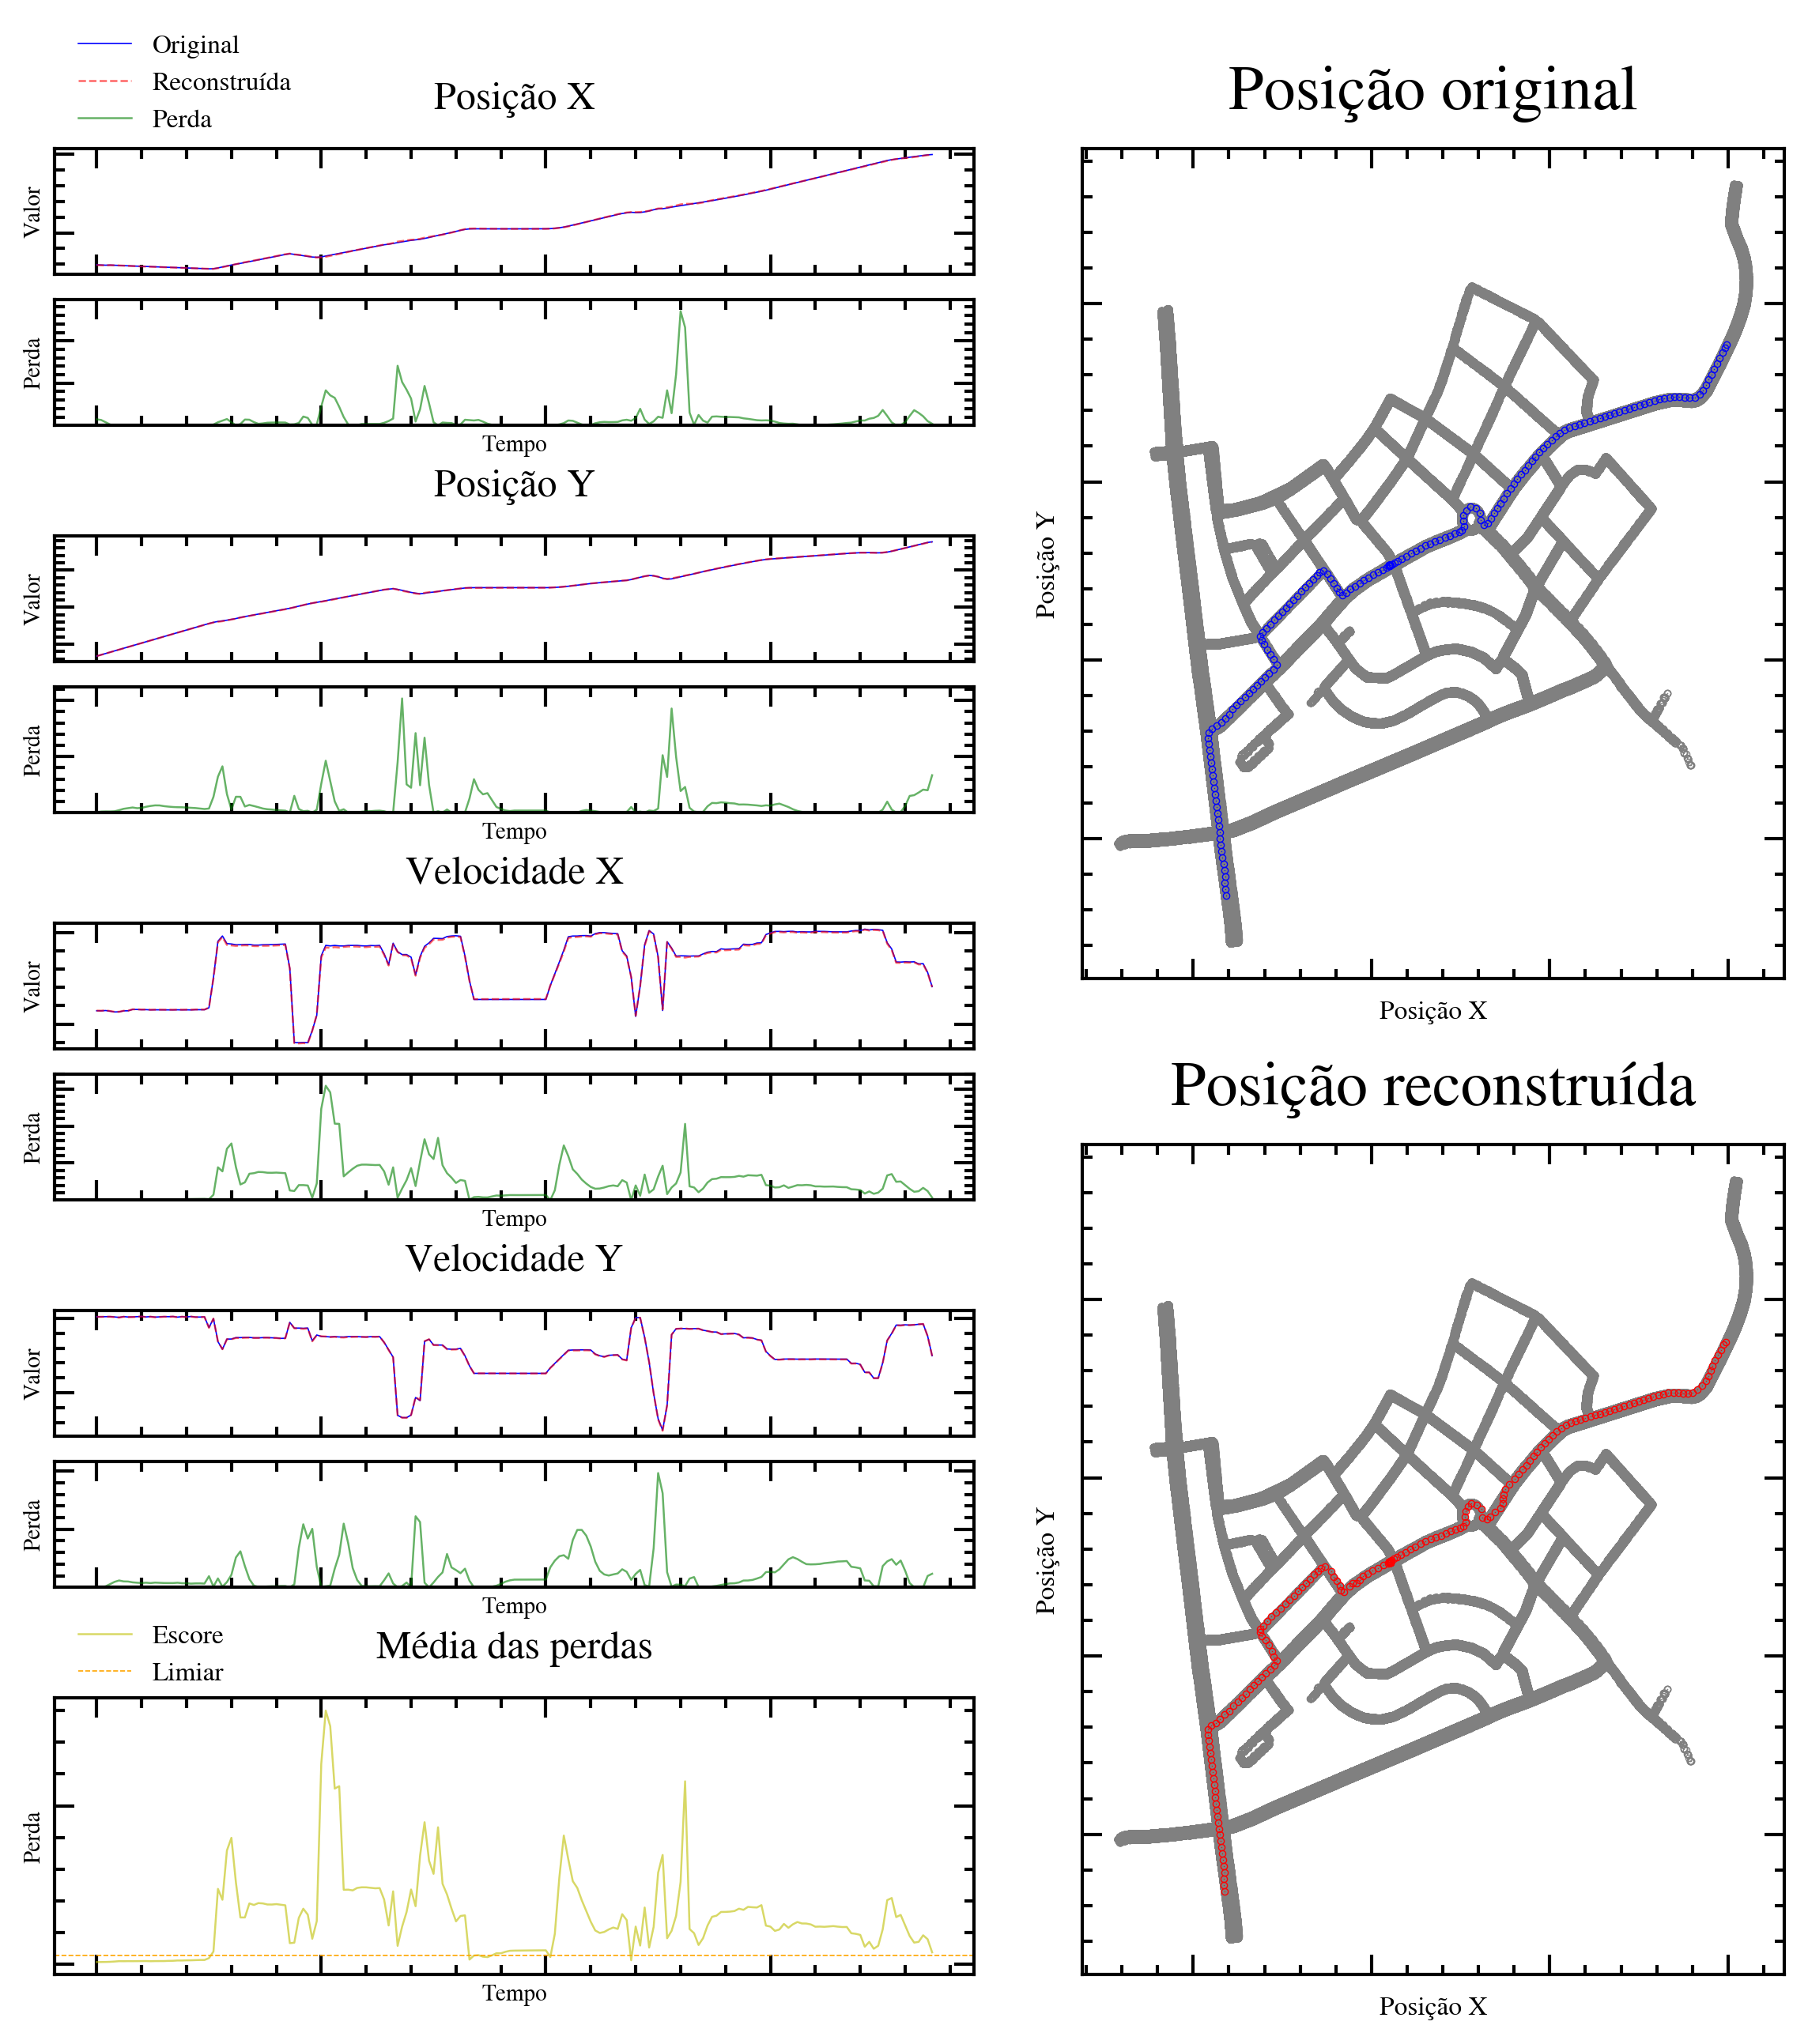

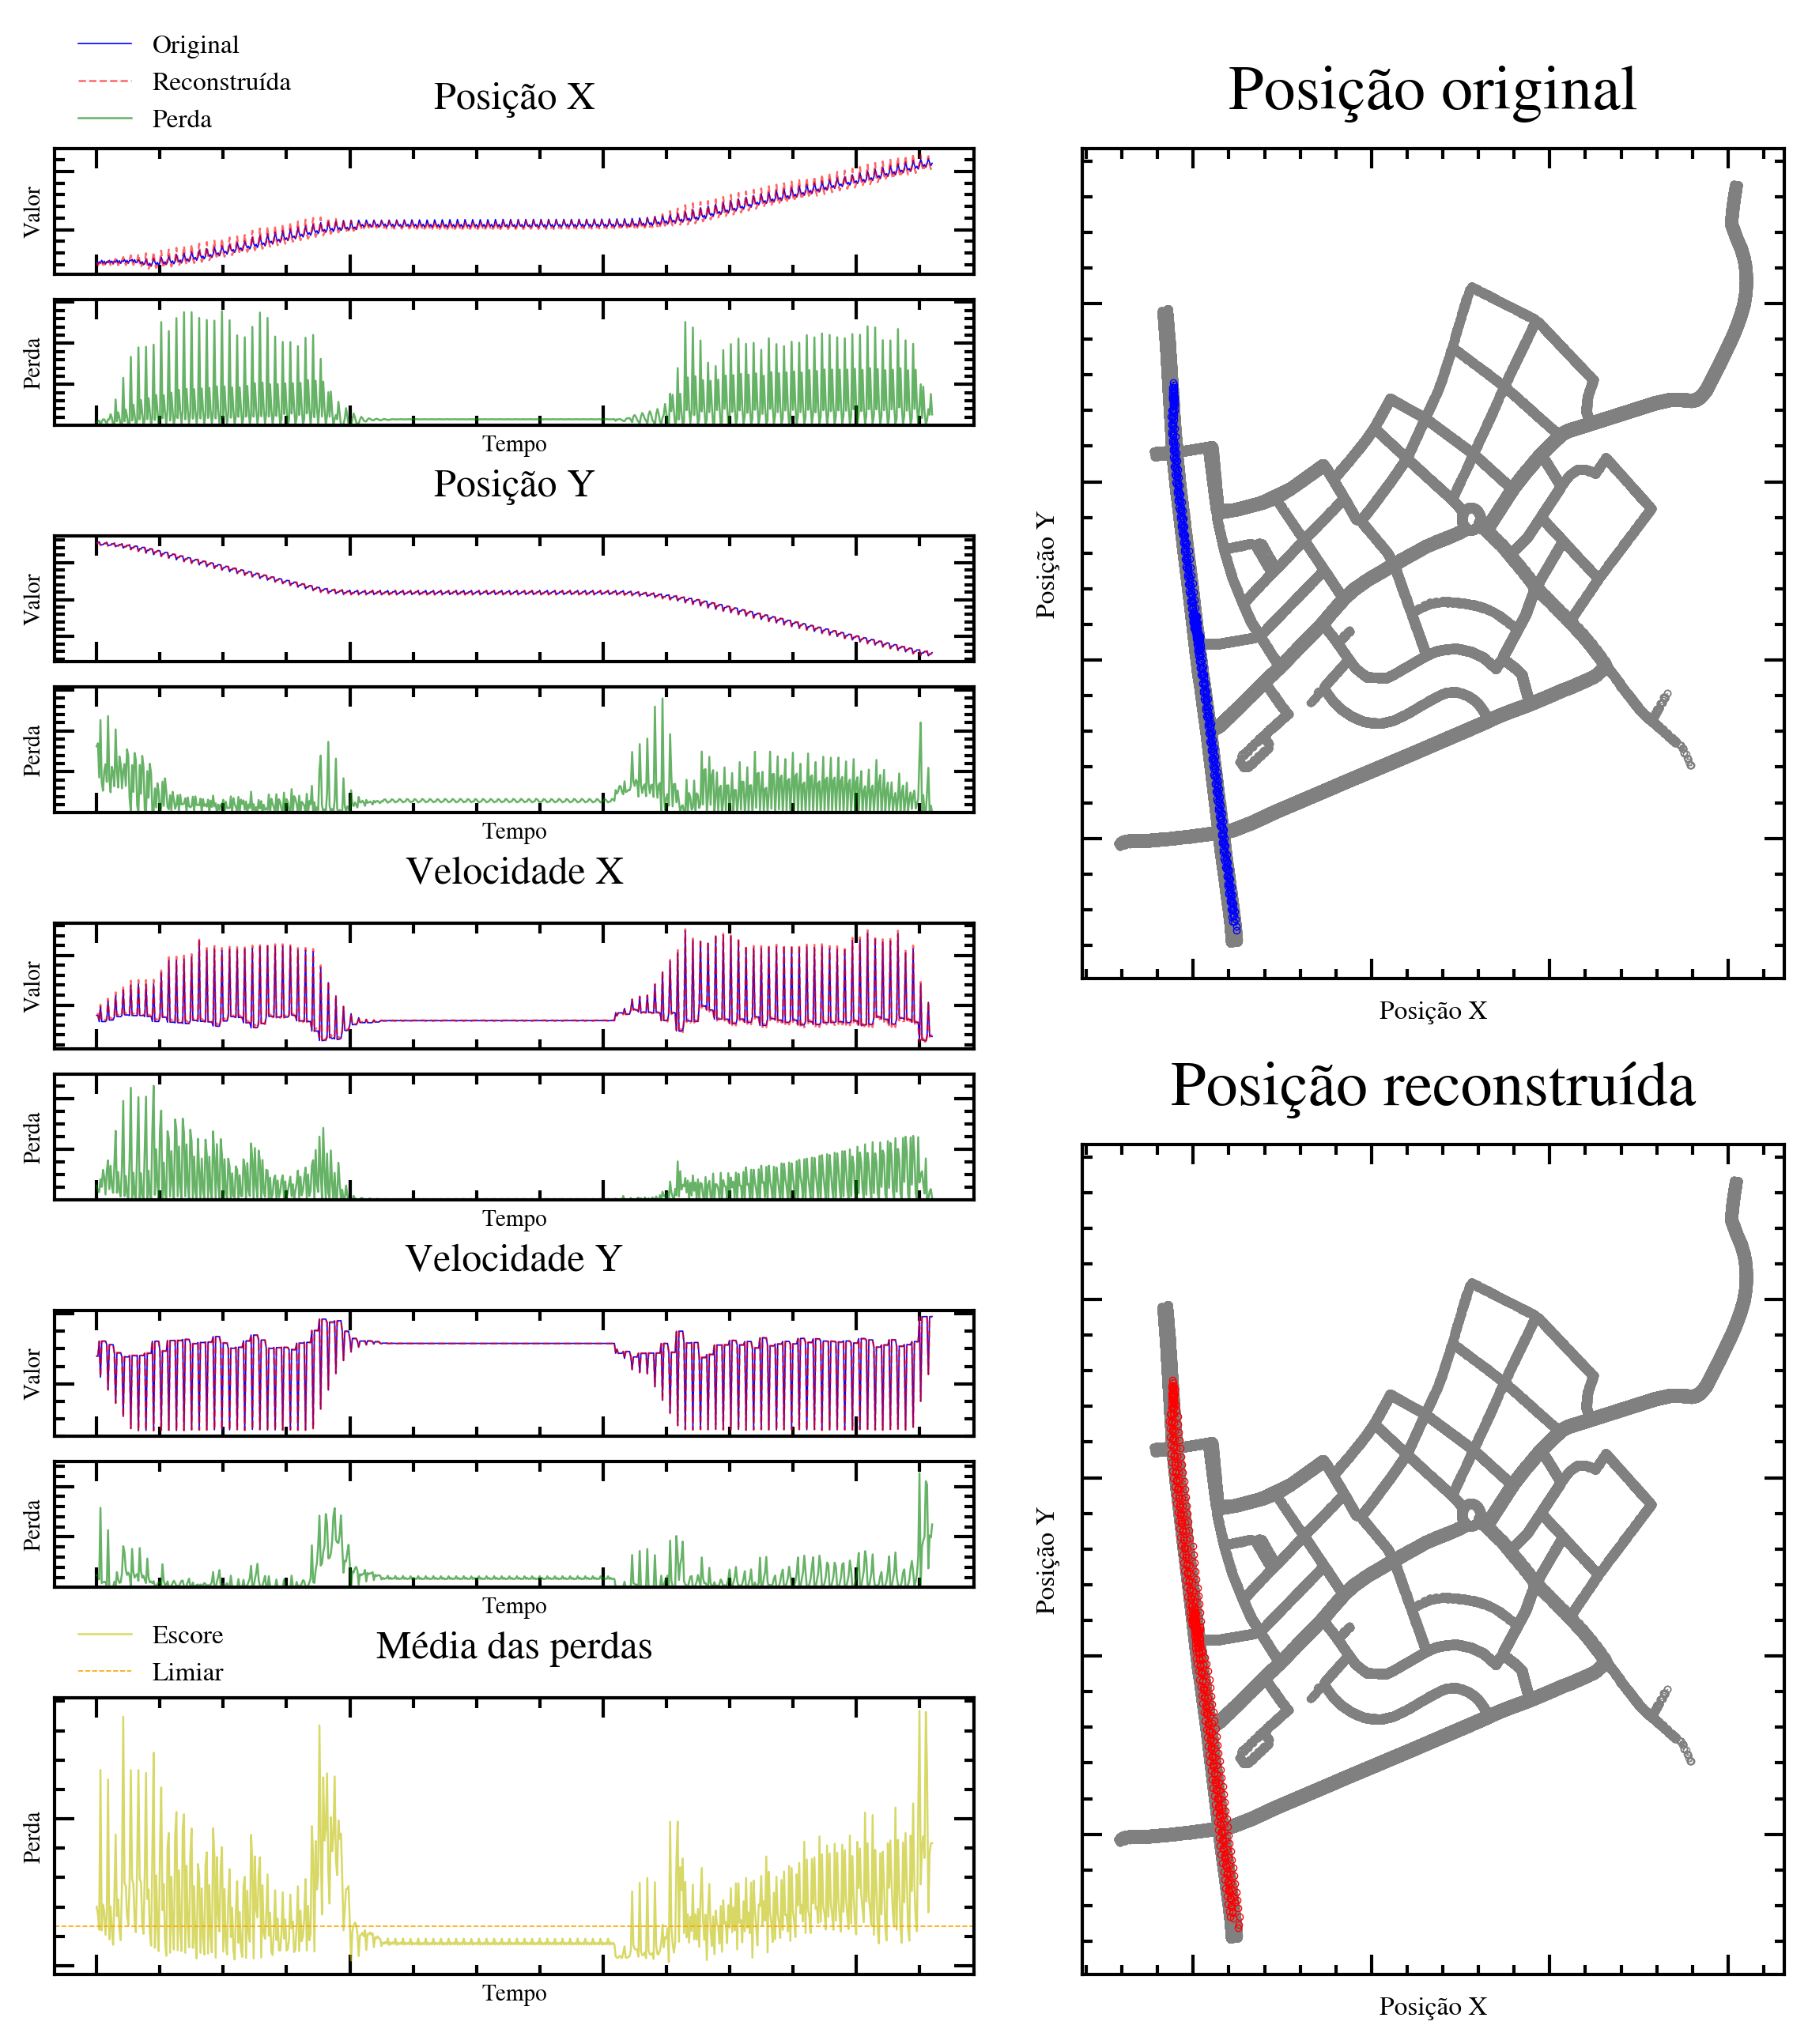

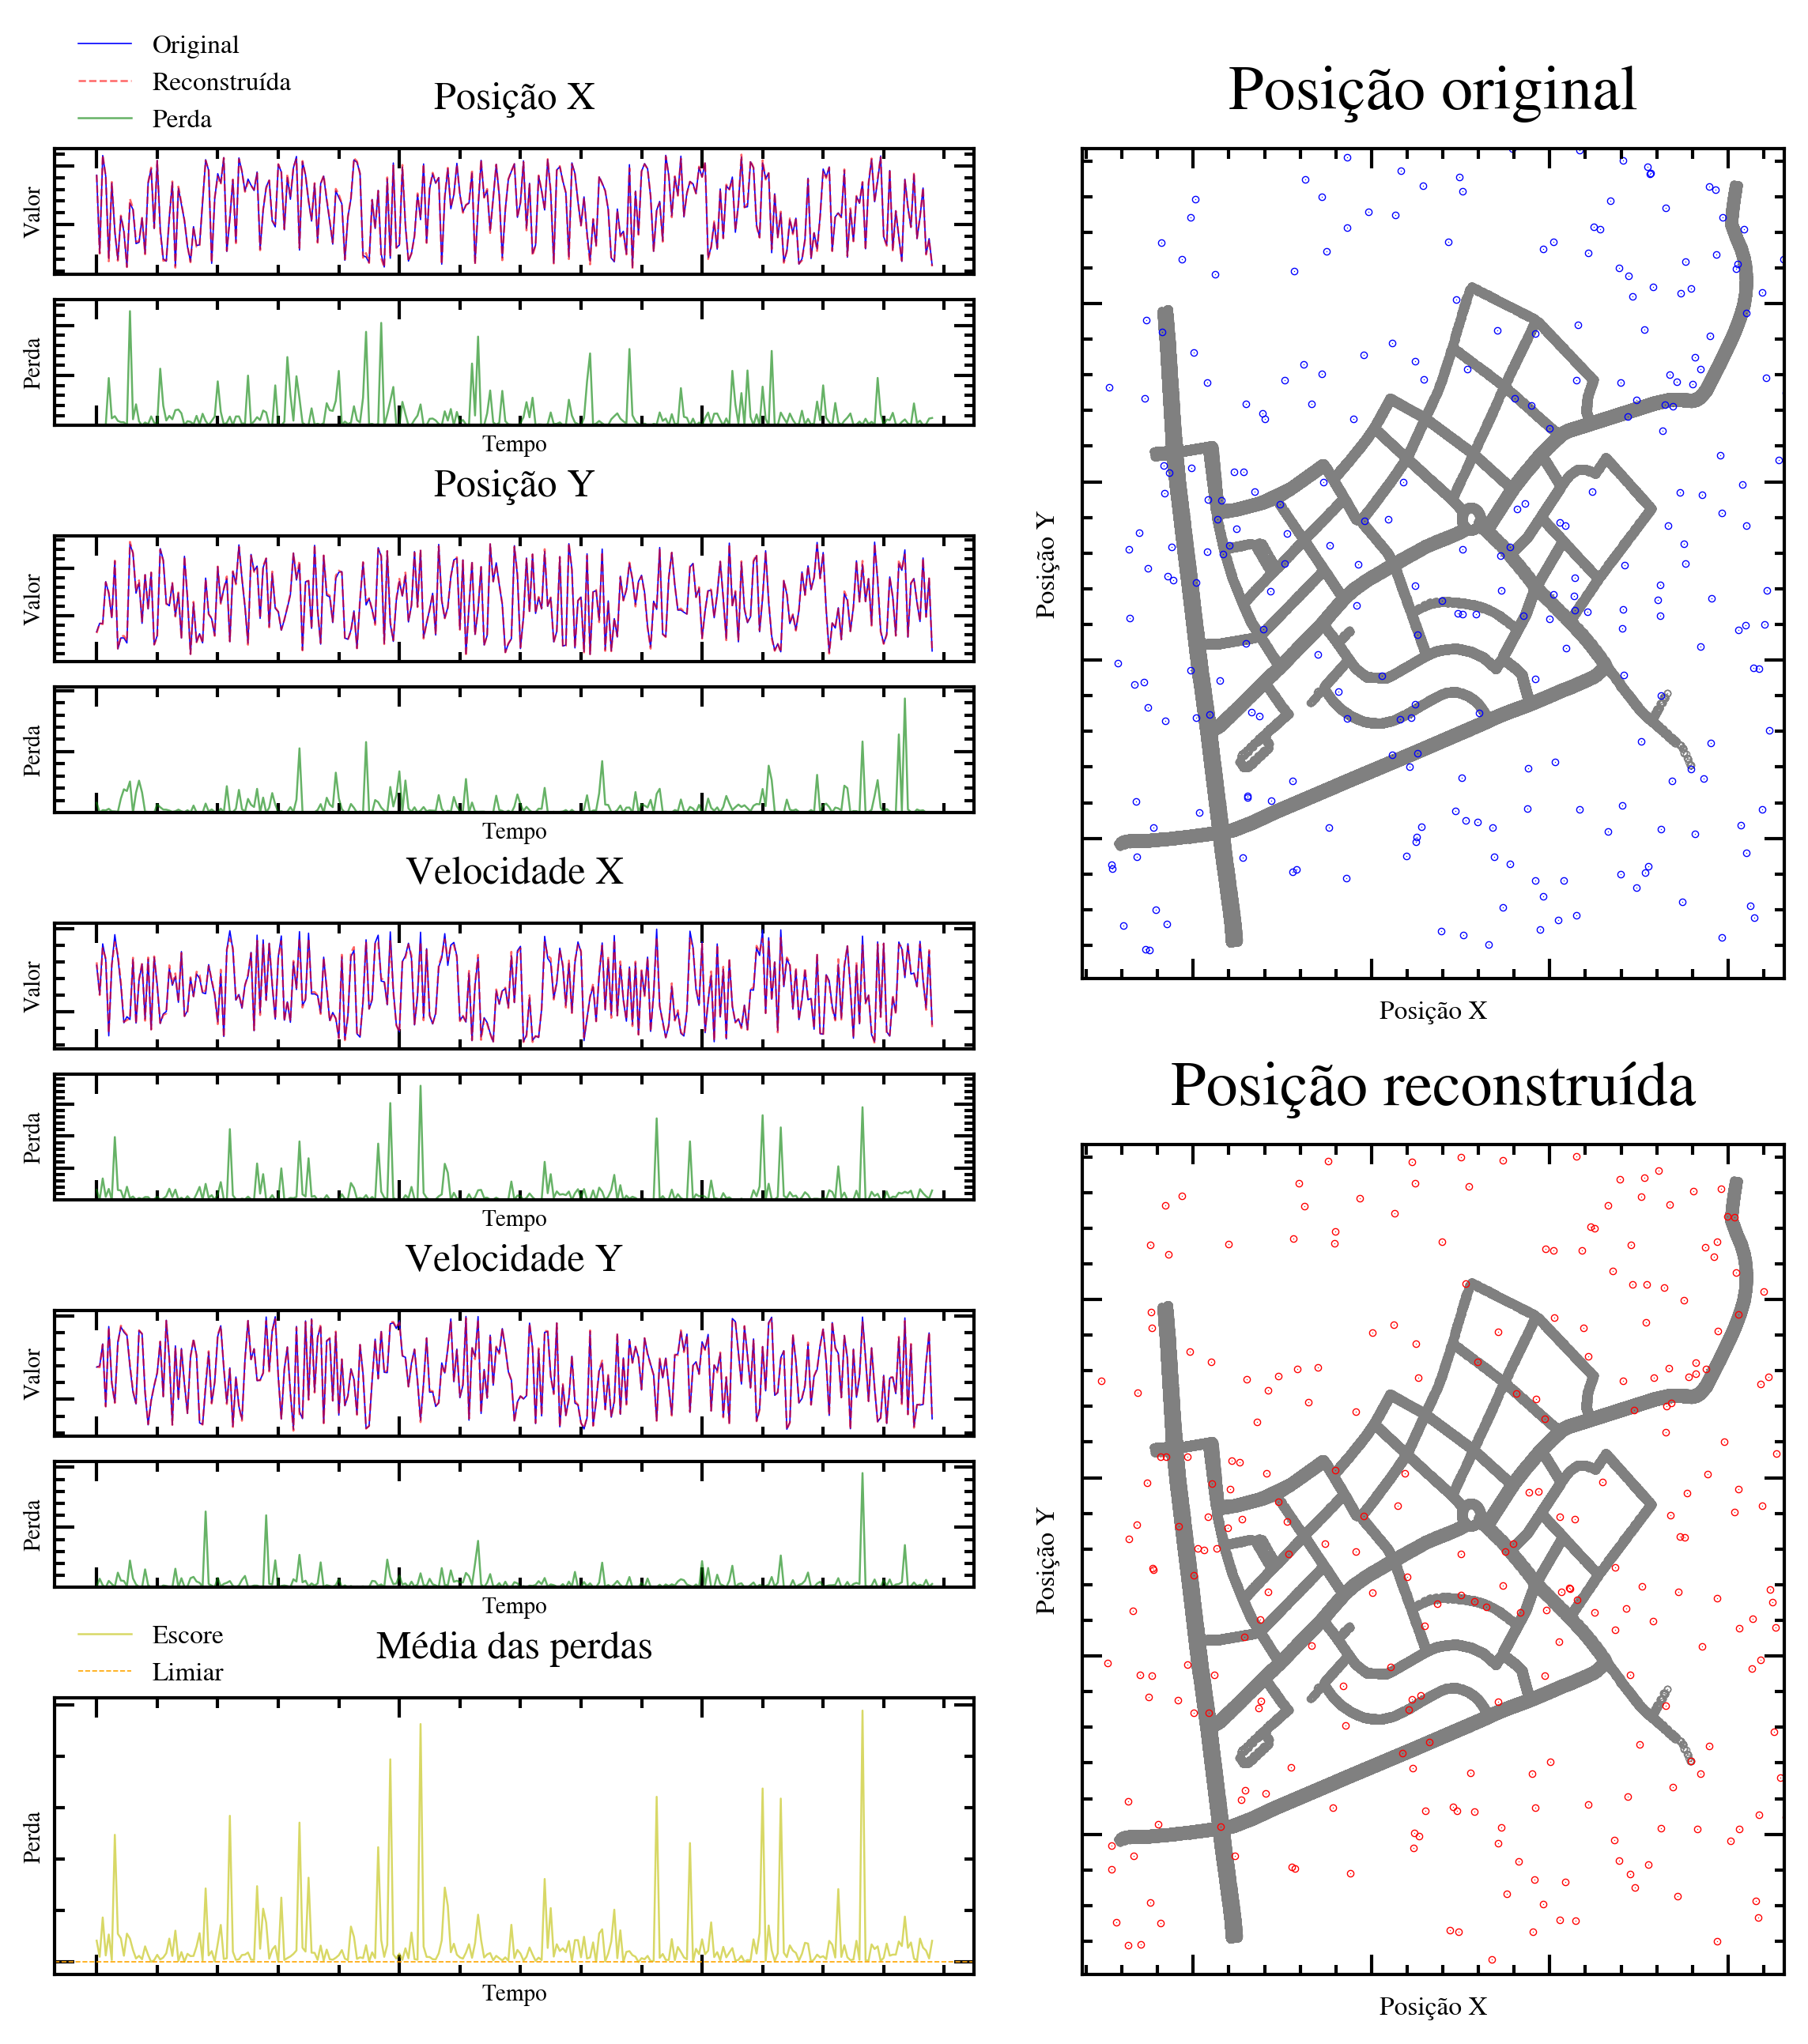

In [143]:
attacks = {
    1147: 'genuine',
    77: 'congestion-sybil',
    564: 'dos-random',
}
model_type = '90' # full 90
model_name = 'tranad' # tranad
for atk, label in attacks.items():
    fig = plot_group(f, atk, T)
    fig.savefig(f'{label}_{model_type}-{model_name}.png', bbox_inches='tight', dpi=800)

In [ ]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure()

gs0 = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

gs00 = gs0[0].subgridspec(nrows=5, ncols=1)

gs000 = gs00[0].subgridspec(nrows=2, ncols=1)

fig.add_subplot(gs000[0])
fig.add_subplot(gs000[1])

gs001 = gs00[1].subgridspec(nrows=2, ncols=1)

fig.add_subplot(gs001[0])
fig.add_subplot(gs001[1])

gs002 = gs00[2].subgridspec(nrows=2, ncols=1)

fig.add_subplot(gs002[0])
fig.add_subplot(gs002[1])

gs003 = gs00[3].subgridspec(nrows=2, ncols=1)

fig.add_subplot(gs003[0])
fig.add_subplot(gs003[1])

gs004 = gs00[4].subgridspec(nrows=1, ncols=1)

fig.add_subplot(gs004[0])

gs01 = gs0[1].subgridspec(nrows=1, ncols=1)

fig.add_subplot(gs01[0])

plt.suptitle("GridSpec Inside GridSpec")
format_axes(fig)

plt.show()

In [8]:
def eval_group_20_10(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    out = model(test)
    if isinstance(out, tuple): out = out[2]
    l = loss(out, test).detach().cpu().numpy()[0]
    return out.detach().cpu().numpy(), l


def plot_group_20_10(h5file, group, thresh, cut_start=True):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][10:, group_idx].reshape(-1, h5file['test'].shape[2])
    # labels = h5file['test_labels'][group_idx, 0]
    
    preds, l = eval_group2(h5file, group_idx)
    preds = preds.reshape(-1, preds.shape[2])
    l = np.mean(l, axis=(0, 2))
    fig, axes = plt.subplots(nrows=2 * (values.shape[1] + 1), ncols=1, sharex=True, figsize=(10, 20))
    
    for i in range(0, values.shape[1] * 2, 2):
        feat = i // 2
        axes[i].title.set_text(str(feat))
        axes[i].plot(smooth(values[:, feat]), linewidth=0.2, color='b')
        axes[i].plot(smooth(preds[0, :, feat]), '-', alpha=0.6, linewidth=0.3, color='r')
        axes[i].grid()
        
        axes[i + 1].plot(smooth(l[:, feat]), '-', alpha=0.6, linewidth=0.3, color='g')
        axes[i + 1].grid()

    axes[-2].plot(smooth(values.mean(axis=1)), linewidth=0.2, color='b')
    axes[-2].plot(smooth(preds[0, :].mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='r')
    axes[-2].grid()
    
    axes[-1].plot(smooth(l.mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='g')
    axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    axes[-1].grid()

loaded test
torch.Size([10, 21277, 17])


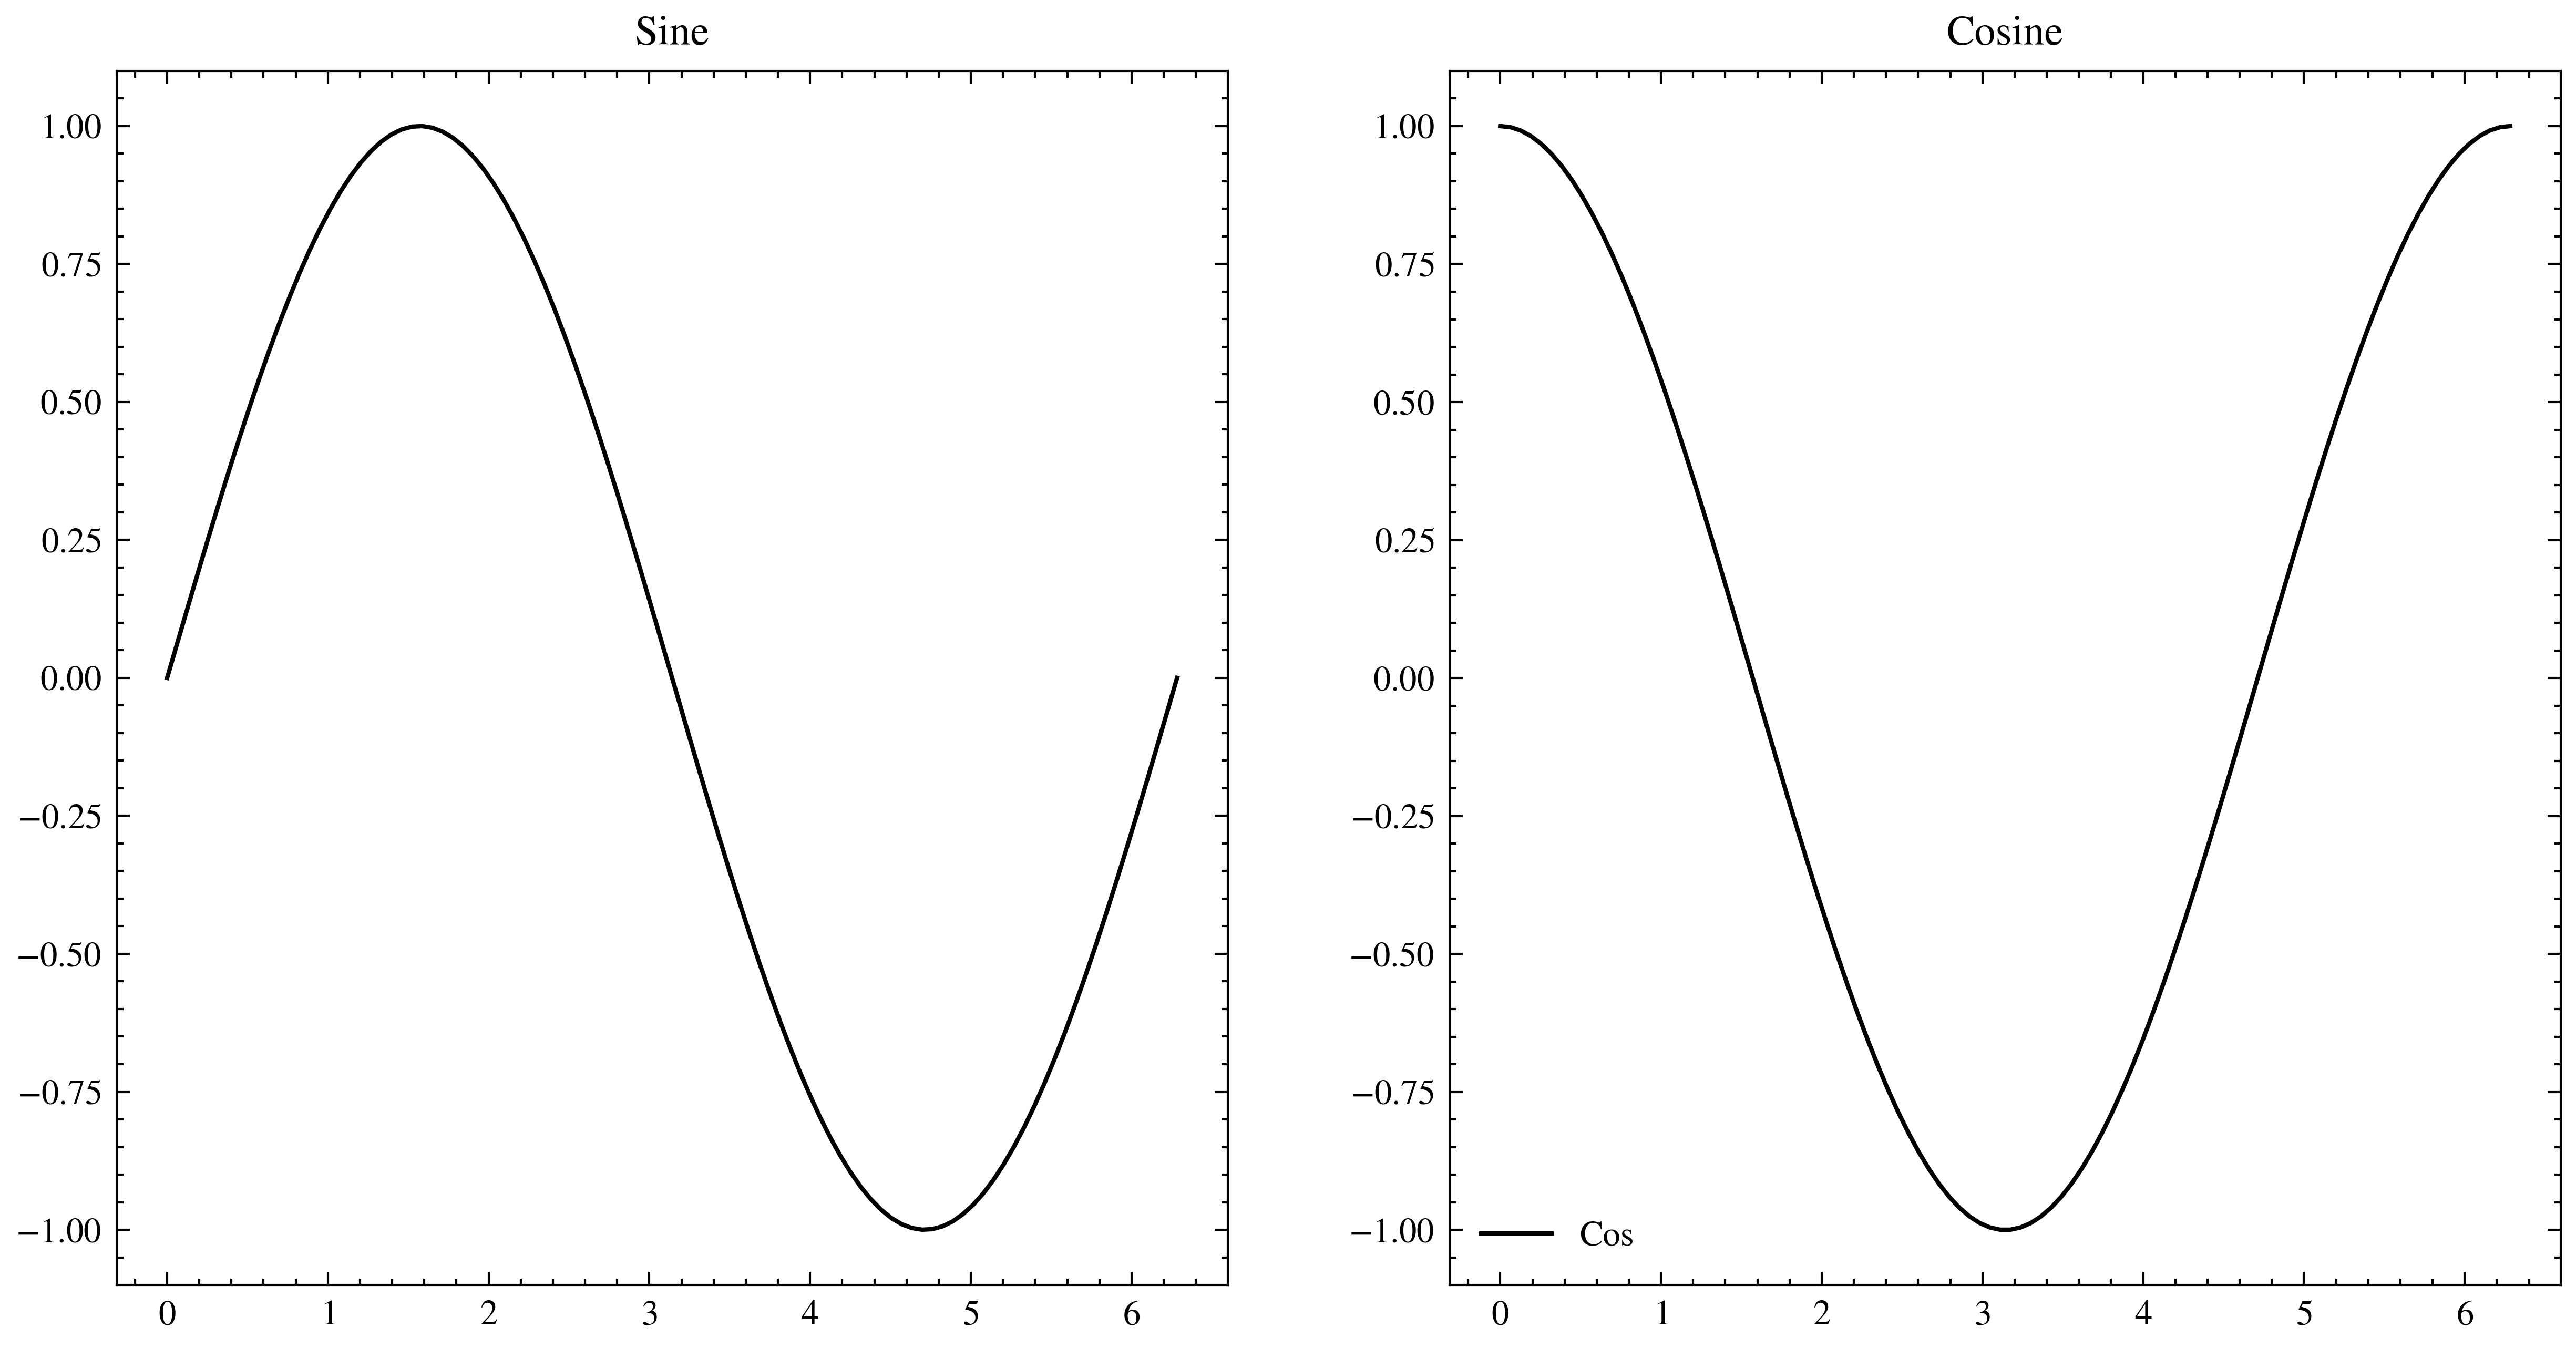

In [535]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 2 * np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the data on the subplots
ax1.plot(x, y1, label='Sin')
ax2.plot(x, y2, label='Cos')

# Set titles for subplots
ax1.set_title('Sine')
ax2.set_title('Cosine')

# Add a legend to one of the subplots
ax2.legend()

# Display the plot
plt.show()
